# Imports
`python -v -c "import torch"`
`Get-ChildItem -Path "C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\Lib\\__pycache__\\sysconfig.cpython-311.pyc" -Recurse -Force -Include __pycache__ | Remove-Item -Recurse -Force`

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning) # TODO: Actually optimize the source of this warning

# Import Dataframe

In [4]:
# Set the path to the file you'd like to load
file_path = "aidedd_blocks2.csv"

# Load the latest version
df_original = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "travistyler/dnd-5e-monster-manual-stats",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

df = df_original.copy()
# Create dataframe to keep track of the original values of each categorical data
original_categorical_vals = pd.DataFrame()

def update_ocv(col, unique):
  global original_categorical_vals
  original_categorical_vals = pd.concat([original_categorical_vals, pd.DataFrame({col:unique})], axis=1)

def reclassify_categorical(df, col):
  df_copy = df.copy()
  unique = df_copy[col].unique()
  update_ocv(col, unique)
  for i in range(0,len(unique)):
    df_copy = df_copy.replace({col: unique[i]}, i)
  return df_copy

def view_categorical_legend(col):
  return original_categorical_vals[col].dropna()

def reclassify_list(df, col, delimiter):
  df_copy = df.copy()
  column = df_copy[col]
  for i in range(0,len(column)):
    num = 0
    item = column[i]
    vals = item.split(delimiter)
    for each in vals:
      each = each.lower()
      if "two" in each: num = num + 2
      elif "three" in each: num = num + 3
      elif "four" in each: num = num + 4
      elif "five" in each: num = num + 5
      else: num = num + 1
    df_copy.at[i,col] = num
  return df_copy

# # print(df.dtypes)
# TODO: Play with category types??
# df_test = df['size'].astype('category')


df = reclassify_categorical(df, 'size')
df = reclassify_categorical(df, 'alignment')
df = reclassify_categorical(df, 'type')
df = reclassify_list(df, 'languages', ", ")
df = reclassify_list(df, 'senses', ", ")
# print(df['attributes'][2].split(" | "))
# print(df['actions'][2].split(" | "))
# print(df['legendary_actions'][2].split(" | "))
view_categorical_legend('alignment')

# temporary removing of string values so I can work only on num values
df = df.drop(['attributes','actions','legendary_actions'],axis=1)
# remove name and source because these don't contribute anything
df = df.drop(['name','source'],axis=1)
# fix numeric values into floats
for each in df.columns:
  if each not in original_categorical_vals.columns:
    df[each] = df[each].astype(np.float32)
  else:
    # df[each] = df[each].astype(int) # apparently it doesn't like integers
    df[each] = df[each].astype(np.float32)

C:\Users\chris\AppData\Local\Temp\ipykernel_26236\2700955696.py:5: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df_original = kagglehub.load_dataset(
C:\Users\chris\AppData\Local\Temp\ipykernel_26236\2700955696.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy = df_copy.replace({col: unique[i]}, i)
C:\Users\chris\AppData\Local\Temp\ipykernel_26236\2700955696.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy = df_copy.replace({col: uniq

# Pytorch Model

In [5]:
# torch_tensor = torch.from_numpy(df.to_numpy())

class MonsterDataset(Dataset):
  # def __init__(self, data, cat_maps):
  def __init__(self, data):
    self.data = data
    # self.cat_maps = cat_maps

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    row = self.data[idx]
    numerical = torch.tensor(row[0], dtype=torch.float32)
    # categorical = {
    #     key: torch.tensor(self.cat_maps[key][row[key]], dtype=torch.long)
    #     for key in self.cat_maps
    # }
    target = torch.tensor(row[0], dtype=torch.float32)
    # return numerical, categorical, target
    return numerical, target


In [6]:
# training_data = MonsterDataset(
#     data=torch_tensor,
# )

# test_data = MonsterDataset(
#     data=torch_tensor,
# )


# train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# This is for image data, not for numerical data...
# # Display image and label.
# train_features, train_labels = next(iter(train_dataloader))
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")
# img = train_features[0].squeeze()
# label = train_labels[0]
# plt.imshow(img, cmap="gray")
# plt.show()
# print(f"Label: {label}")


# Example Data
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


100%|██████████| 26.4M/26.4M [00:03<00:00, 8.31MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 241kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.77MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 5.39MB/s]


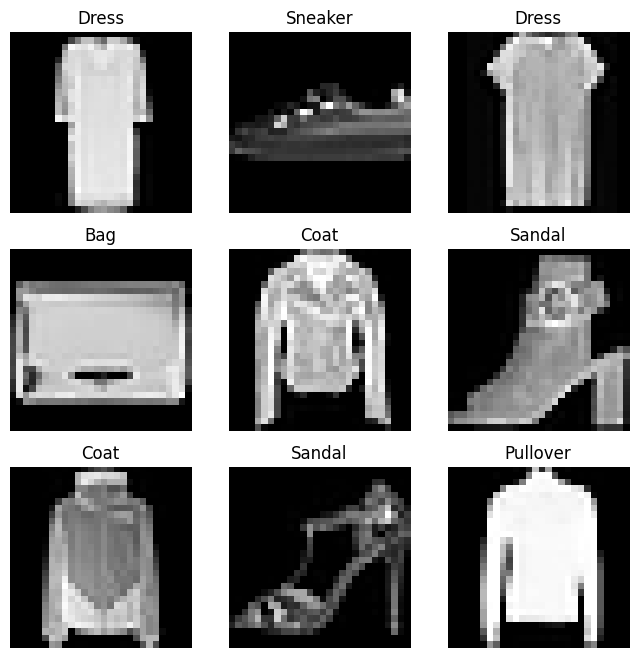

In [7]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Test Code Clipboard

In [8]:




# class Net(nn.Module):

#     def __init__(self):
#         super(Net, self).__init__()
#         # 1 input image channel, 6 output channels, 5x5 square convolution
#         # kernel
#         self.conv1 = nn.Conv2d(1, 6, 5)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         # an affine operation: y = Wx + b
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, input):
#         # Convolution layer C1: 1 input image channel, 6 output channels,
#         # 5x5 square convolution, it uses RELU activation function, and
#         # outputs a Tensor with size (N, 6, 28, 28), where N is the size of the batch
#         c1 = F.relu(self.conv1(input))
#         # Subsampling layer S2: 2x2 grid, purely functional,
#         # this layer does not have any parameter, and outputs a (N, 6, 14, 14) Tensor
#         s2 = F.max_pool2d(c1, (2, 2))
#         # Convolution layer C3: 6 input channels, 16 output channels,
#         # 5x5 square convolution, it uses RELU activation function, and
#         # outputs a (N, 16, 10, 10) Tensor
#         c3 = F.relu(self.conv2(s2))
#         # Subsampling layer S4: 2x2 grid, purely functional,
#         # this layer does not have any parameter, and outputs a (N, 16, 5, 5) Tensor
#         s4 = F.max_pool2d(c3, 2)
#         # Flatten operation: purely functional, outputs a (N, 400) Tensor
#         s4 = torch.flatten(s4, 1)
#         # Fully connected layer F5: (N, 400) Tensor input,
#         # and outputs a (N, 120) Tensor, it uses RELU activation function
#         f5 = F.relu(self.fc1(s4))
#         # Fully connected layer F6: (N, 120) Tensor input,
#         # and outputs a (N, 84) Tensor, it uses RELU activation function
#         f6 = F.relu(self.fc2(f5))
#         # Gaussian layer OUTPUT: (N, 84) Tensor input, and
#         # outputs a (N, 10) Tensor
#         output = self.fc3(f6)
#         return output

# def lineBreak():
#   print("-------------")


# # net = Net()
# # # input = torch.randn(1, 1, 32, 32)
# # out = net(torch_tensor)
# # print(out)
# # lineBreak()
# # net.zero_grad()
# # out.backward(torch.randn(1, 10))


# # print(net)
# # lineBreak()
# # params = list(net.parameters())
# # print(len(params))
# # print(params[0].size())  # conv1's .weight